## Analyzing keio plate 3

This notebook runs the analysis pipeline for the data for Keio plate 3 collected on 08142017.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = "/media/vanvalen/693d2597-3dbf-41bb-b919-341f714e3199/keio_screen/08.14.2017/keio3"
plate_number = 3

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [9]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

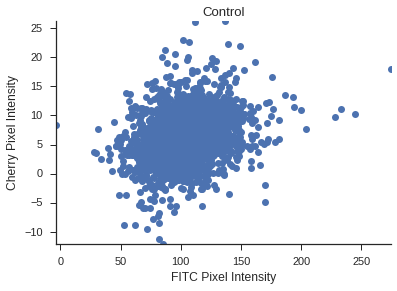

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A9', title = 'Control')
sns.despine()

In [ ]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, plate_number, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


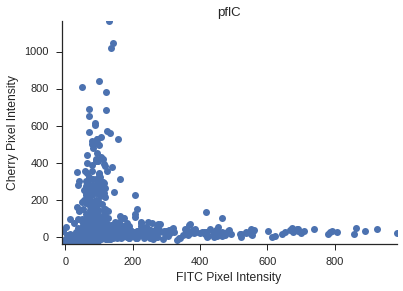

In [21]:
#Print specific wells
well = "B6"
fitc_list = np.array(mean_FITC[well])
cherry_list = np.array(mean_cherry[well])
fig = plt.figure()
plt.plot(fitc_list, cherry_list, 'o')
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
plt.title(pos_to_strain(keio_names_array, plate_number, well))
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

In [22]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A9 2352
G7 1418
G6 3761
G5 5837
G4 465
G3 808
G2 547
G1 1490
G9 1067
G8 1927
B4 756
B5 728
B6 3117
B7 691
B1 338
B2 731
B3 573
B8 1393
B9 645
E9 889
E8 1280
E5 1804
E4 929
E7 689
E6 1766
E1 469
E3 478
E2 1293
H10 573
H11 14219
H12 1252
F12 678
F10 744
F11 879
H8 9464
H9 5416
H2 600
H3 1621
H1 851
H6 383
H7 718
H4 2687
H5 776
D10 605
D11 1935
D12 2667
B12 3375
B10 569
B11 2277
C9 1804
C8 1076
C3 1156
C2 909
C1 378
C7 963
C6 157
C5 640
C4 1642
G12 4872
G11 1231
G10 1242
F1 594
F2 786
F3 810
F4 831
F5 639
F6 1
F7 456
F8 822
F9 652
E11 1753
E10 908
E12 2049
C12 3797
C11 2858
C10 1051
A11 2795
A10 4003
A12 579
A1 2384
A3 2155
A2 1003
A5 1195
A4 5884
A7 1550
A6 1178
A9 1713
A8 1798
D8 1472
D9 812
D6 953
D7 1301
D4 451
D5 474
D2 574
D3 1935
D1 701


In [23]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A9')

In [25]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.182651622003
G6 0.251262961978
G5 0.124892924447
G4 0.189247311828
G3 0.315594059406
G2 0.294332723949
G1 0.204697986577
G9 0.33458294283
G8 0.171250648677
B4 0.246031746032
B5 0.207417582418
B6 0.169072826436
B7 0.146164978292
B1 0.434911242604
B2 0.272229822161
B3 0.347294938918
B8 0.276381909548
B9 0.294573643411
E9 0.335208098988
E8 0.2375
E5 0.14911308204
E4 0.224973089343
E7 0.181422351234
E6 0.203850509626
E1 0.185501066098
E3 0.257322175732
E2 0.243619489559
H10 0.595113438045
H11 0.0595681834166
H12 0.179712460064
F12 0.321533923304
F10 0.176075268817
F11 0.201365187713
H8 0.0408918005072
H9 0.343980797637
H2 0.266666666667
H3 0.242442936459
H1 0.173913043478
H6 0.287206266319
H7 0.25348189415
H4 0.118347599553
H5 0.180412371134
D10 0.19173553719
D11 0.222739018088
D12 0.115860517435
B12 0.330666666667
B10 0.203866432337
B11 0.256038647343
C9 0.458980044346
C8 0.186802973978
C3 0.23875432526
C2 0.223322332233
C1 0.37037037037
C7 0.224299065421
C6 0.197452229299
C5 0.18281

atoS 99 192
cheB 29 64
phoQ 41 148
None 153 423
frdD 32 77
pflD 25 76
mdh 58 131
nuoB 15 60
nuoL 66 140
pps 40 212
adhE 72 265
ybiW 14 47
atoC 14 34
cheA 37 54
phoP 13 57
citA 8 31
frdC 26 37
pflC 82 209
yhfW 22 30
nuoA 65 119
nuoK 42 34
None 25 33
acnA 43 161
None 49 391
evgA 23 31
uvrY 32 52
narL 38 69
citB 12 34
frdB 24 28
ppc 0 11
rpe 23 45
glk 22 46
nuoJ 93 191
zwf 43 52
gapC 12 48
pflA 41 462
evgS 42 43
yedV 26 34
narX 31 185
None 19 31
frdA 17 28
aceB 21 35
pck 21 67
maeB 35 108
nuoI 26 49
pykA 15 34
gapC 36 83
pflB 32 121
narQ 10 31
None 46 82
rssB 30 36
kdpD 45 64
deoB 41 70
aceA 38 140
gpmI 9 15
talA 33 98
nuoH 31 46
gnd 11 60
None 59 47
None 36 96
yfhA 7 32
baeS 27 52
rstA 38 29
dps 27 75
ytjC 23 38
pfkA 23 130
tktB 13 68
nuoG 11 24
mqo 19 28
fumC 14 54
appC 17 48
None 24 116
narP 14 24
rstB 18 84
None 7 30
phoB 60 372
rpiB 107 395
tpiA 17 83
cusB 57 90
nuoF 49 111
nuoN 55 80
fumA 25 118
appB 49 434
None 12 59
rcsB 4 55
cheY 48 135
torR 33 109
phoR 7 53
fumB 7 25
fsaB 16 34


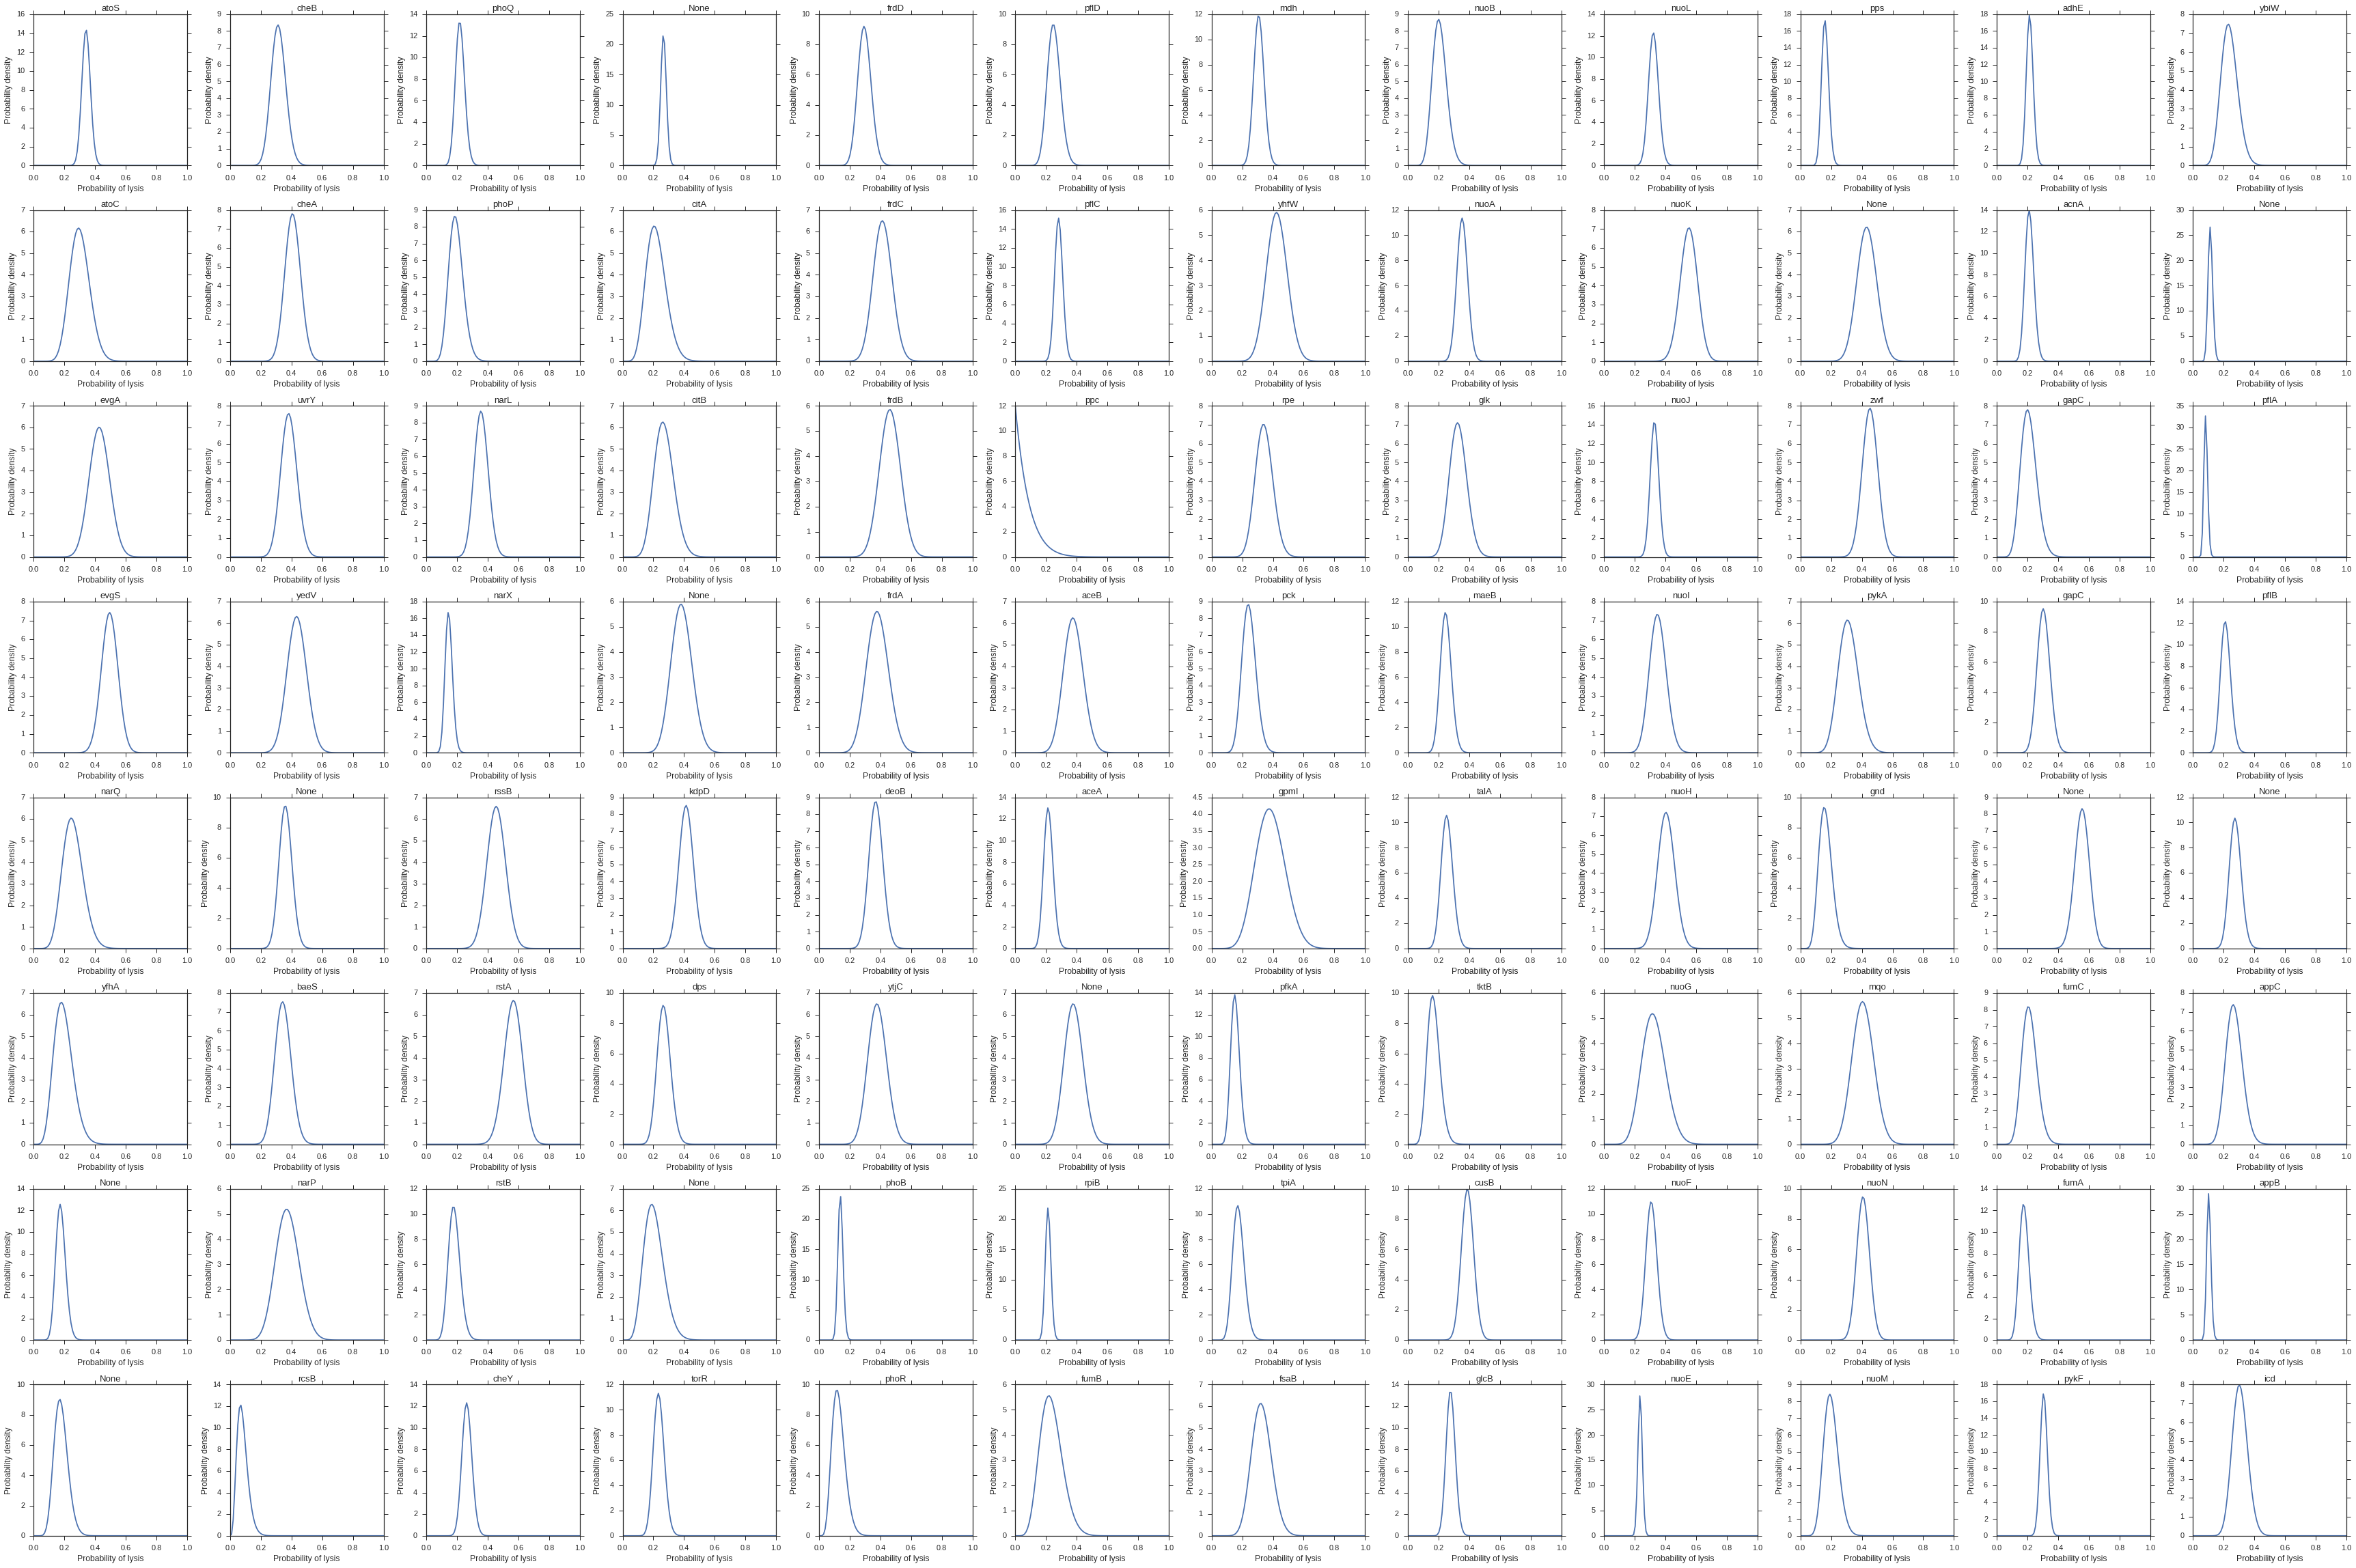

In [27]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A9'])
cherry_control_array = np.array(mean_cherry_control['A9'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            print well_name, counter, len(p_fitc)-counter
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

hflC 1 134


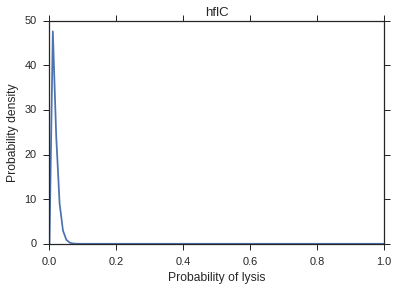

In [18]:
well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1
                
if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    print well_name, counter, len(p_fitc)-counter
    x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1
    fig = plt.figure()
    axes = plt.gca()
    axes.plot(x, posterior)
    axes.set_xlim([0, 1])
    axes.set_xlabel('Probability of lysis')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)

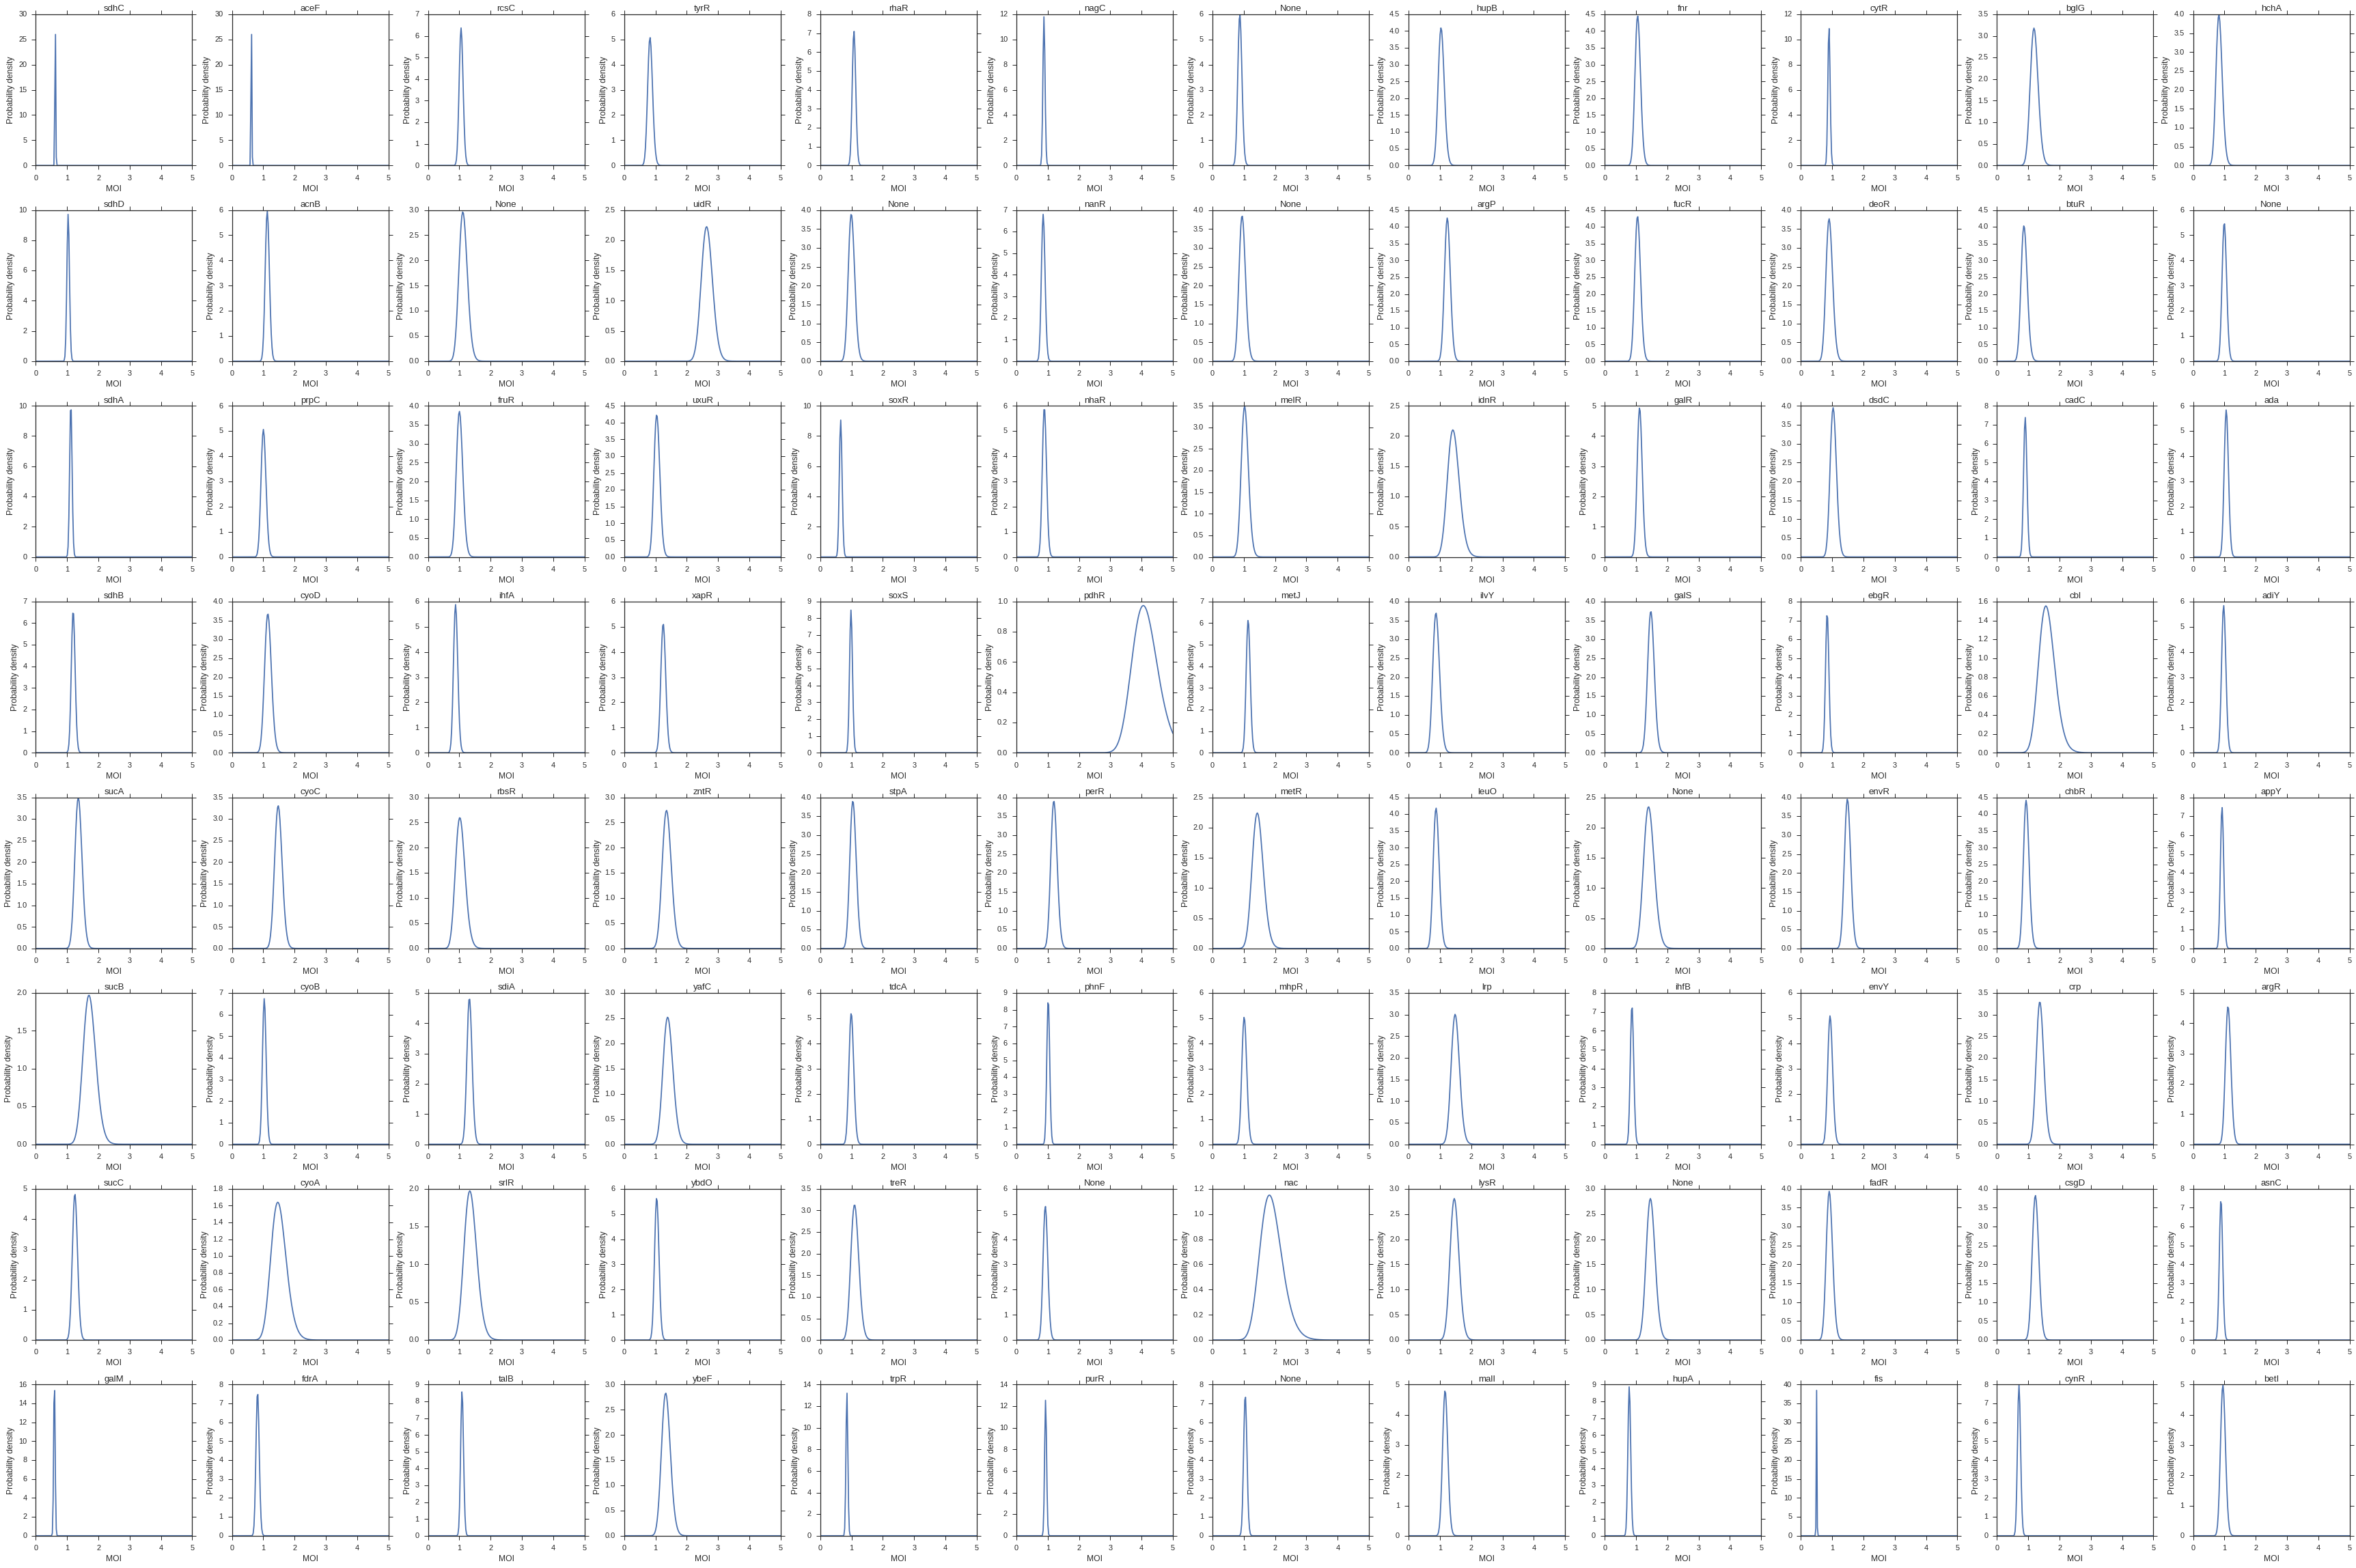

In [22]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()

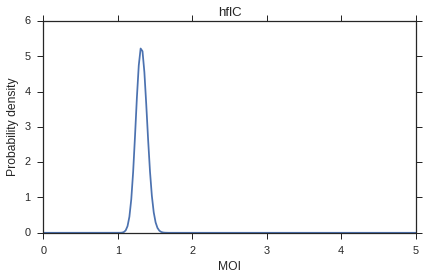

In [20]:
fig = plt.figure()
axes = plt.gca()

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1

if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
else:    
    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
            
plt.tight_layout()